# Chapter 2: Linear, Trend, and Momentum Forecasting
Prepared by: Marissa P. Liponhay and Maria Eloisa M. Ventura

In this chapter we introduce basic tools on forecasting, which utilize simple algebraic formula. In the previous chapter, ARIMA was discussed where the future values of a time series are forecasted using its past or lagged values. It was shown that ARIMA can only be applied after removing the trend and seasonality of the data. We note however that for some forecasting tools, the trend is relevant and is part of the formula for prediction. In this work, forecasting will be demonstrated while making use of the relationships and trends in the data. 

In the first half of this notebook, we demonstrate forecasting by fitting time series data with linear regression. For the second half, we demonstrate that by using the trends of the time series data such as moving averages, we can predict the possible future direction of the trend using momentum forecasting. 

Lastly, it is important to note that the concept of moving average (MA) in ARIMA is not the same in this chapter since the moving average that will be discussed is just the classical definition of MA.

### How to Use This Notebook
This chapter is divided into two parts mainly about: (a) linear regression and (b) trend and momentum forecasting  using moving averages. In each section, the theory is discussed followed by examples that are implemented in Python 3. The chapter outline can be seen in the __[readme](readme.txt)__ file for this chapter.


## Linear Regression (LR) Forecasting 
Linear regression forecasting is used when forecasting a time series y, with the assumption that it has a linear relationship with another time series x. 

The basic equation in doing linear regression is:
$y= mx + b $

where $m$ is the slope of the linear fit and $b$ is the $y$ intercept which represents error in the fit. Usually in forecasting, $y$ is replaced by $\hat{y}$ to symbolize the forecasted value.

Given a data set, one can easily compute for the slope of the data manually or automatically using excel built-in trendline functions. To manually calculate $m$, the following equation is used:

$m = {\frac{\sum\limits _{i=1} ^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sum\limits _{i=1} ^{n}(x_{i}-\bar{x})^2}}$

To automatically calculate it in excel, one only needs to place a linear 'trendline' into the scatter plot of the data. 

This method is called the Ordinary least squares (OLS). A more general equation of LR using OLS is given as:

$y= mx + b + \mu_{i}$

where $\mu_{i}$ represent the outliers or the terms that cannot fit into the regression line.


OLS quantifies the  evaluation of different regression lines. Using OLS, the regression line that minimizes the sum of the squares of the differences between the observed dependent variable and the predicted dependent variable is chosen as the best fit. 

But what if there are outliers causing the best regression by OLS do not really fit the data? This leads us to check when OLS can be applied to a data set. The following are the assumptions that are necessarily met before we can apply OLS.


#### Gauss Markov Assumptions 
The following assumptions for sampled data (from a population) should be met so that the parameters calculated using OLS indeed represent the best unbiased estimator of the population parameters.

1. Linearity in parameters. This assumption requires that parameter $m$ is linear. (Independent variable is not required to be linear).

2. Both the independent and dependent variables $(x,y)$ are random variables. This will result to zero autocorrelation of outlier or the residual term.

3. For multivariate regression method,there should be no perfect collinearity between multiple independent variables. To test for the presence of collinearity, $R^{2}$ is good. 

4. The outlier aka residual term $\mu$ is endogenous, such that $cov(\mu_{i}, x_{i})=0$=0. 

5. Homoscedasticity in residual term $\mu_{i}$, in other words, the variance of $\mu_i$ is independent of $x_i$.

6. The residual term $\mu_{i}$ have zero autocorrelation, i.e., $cov(\mu_{i}, \mu_{j})=0$.


Using OLS for time series data, the samples are drawn from the same process, and we can no longer assume that the independent variable $x$ is random variable. In this case, the assumptions (4-6) should be strictly met by all $x$ at all points.


### Example 1: Univariate LR in Stock Price of Netflix
Linear regression is one of the most successful tools used in technical analysis of prices and is widely available as a charting tool. For the sake of demonstration, we will use the historical data of Netflix downloaded from Yahoo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline
#from sklearn.model_selection 

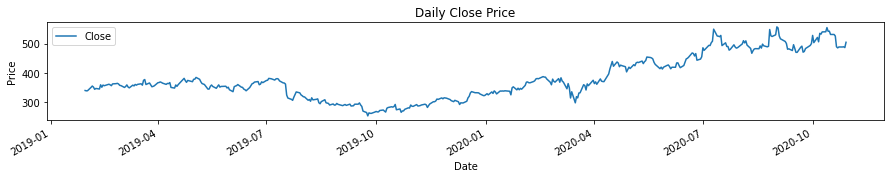

In [2]:
price = pd.read_csv('../data/NFLX3.csv',usecols=['Date', 'Close'], parse_dates=['Date'])
price.set_index("Date", inplace=True)

plt.rcParams["figure.figsize"] = (15,2)
ax=price.plot()
plt.ylabel('Price')
# plt.grid()
ax.set_title('Daily Close Price')
plt.show()

#### Testing for Stationarity
We have learned from the previous chapter that one of the first steps to do when doing time series forecasting is to check the stationarity of the data, especially when there is a prominent trend. In this notebook, we will use the most widely used statistical test called the Augmented Dickey-Fuller, a unit root test. Note that a unit root test determines how strongly a time series is defined by a trend. The test uses an autoregressive model and optimizes an information criterion across different lag values. Recall that:


Null Hypothesis (H0): 
- The time series has a unit root and is non-stationary. It is time dependent.

Alternate Hypothesis (H1): 
- The time series does not have a unit root and is stationary. It is not time-dependent.

Finally, the result of the test can be interpreted using the ADF Statistic, i.e., the ADF statistic should be lesser than the critical values for the data to be considered stationary.

In some references, they use p-value from the test. A p-value below a threshold (such as 5% or 1%) implies a stationary time series, otherwise the data is non-stationary.

p-value <= 0.05: The time series is stationary.

p-value > 0.05: The time series is non-stationary.

In other references, they simply compare the ADF statistic to the critical values, such that if it is greater than the critical values, the time series is said to be non-stationary.

In [3]:
from statsmodels.tsa.stattools import adfuller
series = pd.read_csv('../data/NFLX3.csv',usecols=['Close'])
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.027586
p-value: 0.956190
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


Based on the results, the time series in non-stationary at all significance levels (1%,...) as the ADF statistic is greater the the critical values.

#### Testing for Autocorrelation
The autocorrelation coefficient measures the strength of the relationship between the data and its lag. The first coefficient measures the relationship between $y_{t}$ to $y_{t-1}$, while the second coefficient measures the relationship between $y_{t}$ to $y_{t-2}$, and so on.

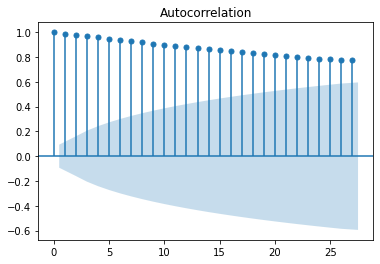

In [4]:
# testing autocorrelation using pandas tools.
plt.rcParams["figure.figsize"] = (6,4)
tsaplots.plot_acf(price)
plt.show()

Another way to visualize the autocorrellation using pandas tools with respect to lag is shown below.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

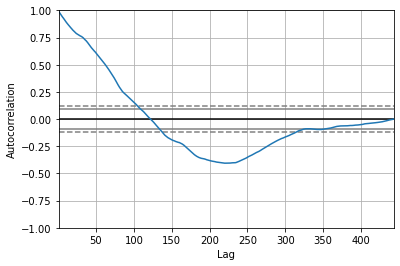

In [5]:
plt.rcParams["figure.figsize"] = (6,4)
autocorrelation_plot(price)

One can better imagine the concept of lagged autocorrelation if we make the lagged data as a moving version of the original data and look at the overlap (in this case, their autocorrelation). If the trends of the original are both goin up or down as the lagged data is moved, the correlation is positive, otherwise negative.

Referring back to the autocorrelation plot vs lag, the plot shows that as the lag increases, the trend decreases. The strong relationship of the data with the first 100 lags shows that $y$ is not purely random as stated in the Gauss-Markov assumption. At lag of approximately equal to 120 days, the autocorrelation is zero and starts to be negative. This is because the trend of the lagged data becomes negative in contrast to the positive trend of the data. 

Here we see that after approximately $y_{t-320}$, the autocorrelation is zero. This is mainly because the overlap of the lagged data and the original data is minimal as less and less data are overlapped.

Now assuming that 4-6 are met, we will now apply linear regression to the price of NFLX to predict the prices for the next month on a daily basis.

<AxesSubplot:xlabel='Date'>

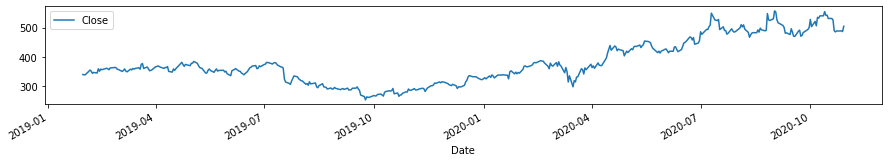

In [6]:
# Let us create another variable to manipulate rather than using the original data 

window = 30
price2 = price[['Close']]
plt.rcParams["figure.figsize"] = (15,2)
price2.plot()
# plt.grid()

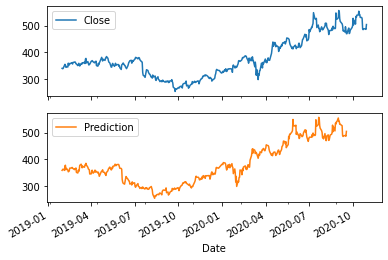

In [7]:
# With the goal of predicting the future prices daily for a month (30days), we create a variable to contain the size
# it will be placed at the end of a variable 'Prediction' in the dataframe that is shifted by 30 days
plt.rcParams["figure.figsize"] = (6,4)
price2['Prediction'] = price2[['Close']].shift(-window)

price2.plot(subplots=True)
plt.show()

In [8]:
print(price2[['Close']].shape)

(443, 1)


In [9]:
print(price2[['Prediction']].shape)

(443, 1)


In [10]:
# Now we will use the original data on prices as X, the predicted data as y and use 80% of the data as training set 
# while 20% of the data as test set and use sklearn function to train and test the data.
# for both variables, the last 30 values are removed.

X = np.array(price2[['Close']])
X = X[:-window]
print(len(X))

y = np.array(price2['Prediction'])
y = y[:-window]
#print(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)


413


In [11]:
print(X.shape)

(413, 1)


Now the data is ready for linear regression training and fitting using sklearn. 

In [12]:
lr = LinearRegression()
fit = lr.fit(x_train, y_train)

In [13]:
print(y_train.shape)

(330,)


In [14]:
## coefficients of linear fit are:
b = fit.intercept_
m = fit.coef_

print("the equation of the linear fit is: ")
print('y= ', m, 'x + ', b)

# checking R^2
R_sqd = lr.score(x_test, y_test)
print("lr confidence: ", R_sqd)

the equation of the linear fit is: 
y=  [0.98010473] x +  17.065244311865115
lr confidence:  0.720499481096278


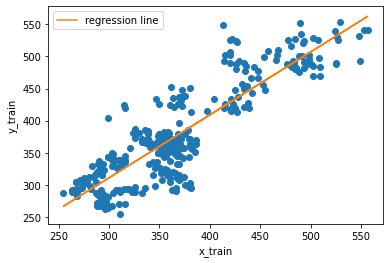

In [15]:
# To show the relationship of the training set and the predicted prices.. we plot the following.
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(x_train, y_train, 'o')
plt.xlabel('x_train')
plt.ylabel('y_train')
plt.plot(x_train.flatten(), lr.predict(x_train), label='regression line')
plt.legend()

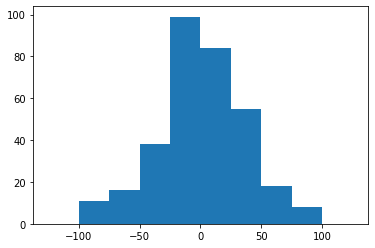

In [16]:
# Here is an attempt to show that the difference between the training set and the predicted values are almost Gaussian
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(lr.predict(x_train)-y_train, bins=np.arange(-125, 126, 25))
plt.show()

In [17]:
# Setting the last 30 rows of the original Close price as test data 
# to predict the next values. 
x_forecast = np.array(price2.drop(['Prediction'],1))[-window:]
print(len(x_forecast))

# # we predict the closing prices...
lr_prediction = lr.predict(x_forecast)
print(len(lr_prediction))

30
30


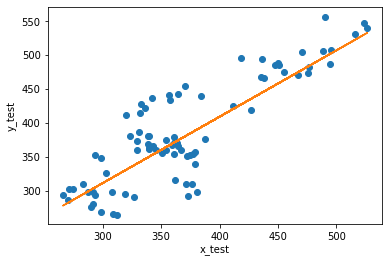

In [18]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(x_test, y_test, 'o')
plt.xlabel('x_test')
plt.ylabel('y_test')
plt.plot(x_test.flatten(), lr.predict(x_test))
# plt.legend()

Now, we try to plot the predicted values over the original time series.  

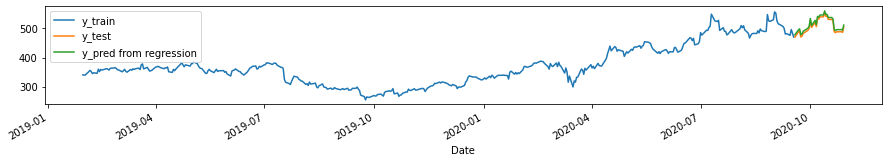

In [19]:
plt.figure(figsize=[15, 2])
price2.loc[~price2.Prediction.isnull()].Close.plot(label='y_train')
price2.loc[price2.Prediction.isnull()].Close.plot(label='y_test')
pd.Series(lr.predict(price2.loc[price2.Prediction.isnull()][['Close']].values), 
          index=price2.loc[price2.Prediction.isnull()].index, 
          name='Pred_LR').plot(label='y_pred from regression')
plt.legend(loc=2)

In [20]:
# checking R^2
R_sqd_train = r2_score(y_pred=lr.predict(x_train), y_true=y_train)
print("Train set R^2: ", R_sqd_train)

## R^2 of the predicted vs the actual closing price...
R_sqd_test = r2_score(y_pred=lr_prediction, y_true=y[-window:])
print("Test set R^2: ", R_sqd_test)

# checking for the MAE values:
print("The mean absolute error, MAE is: ", metrics.mean_absolute_error(lr_prediction, x_forecast))

Train set R^2:  0.7682299277930607
Test set R^2:  0.9187750163794539
The mean absolute error, MAE is:  6.973973107834818


#### Compare with model where $X=X_{t-1}$
Here, we check the R^2 value with respect to the lagged series.

In [21]:
r2_score(price.Close.iloc[:-1], price.Close.iloc[1:])

0.9814904294769093

In [22]:
# Setting the last 30 rows of the original Close price as the variable x_forecast2 and using it as the 
# test data to predict the next values. 

x_forecast2 = np.array(price2.drop(['Prediction'],1))[-window:]
# print(len(x_forecast))

# # we predict the closing prices...
lr_prediction2 = lr.predict(x_forecast2)
print(len(lr_prediction))

30


Now we check the relationship between the test data and the prediction, we see that there is a perfect linear relationship as seen below.

In [23]:
import scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_forecast.flatten(), lr_prediction2)

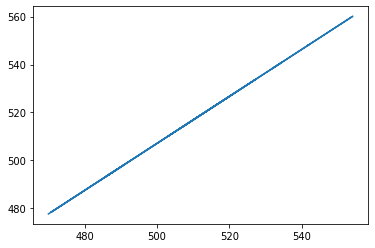

In [24]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(x_forecast2.flatten(), lr_prediction2)

### Example 2. Univariate Forecasting using Jena Climate Data
We will use the temperature values of the data in this part of the chapter to see if we can forecast the next 24hr temperature values. For this book, the data has been divided into training_series, validation_series, and test_series as described in the preface. In this chapter, I do not need perform any validation procedure, thus I will combine the training and validation series and it will serve as my raw data. We will then follow the steps outlined in Example 1 and see the average MAE of the prediction using linear regression.

In [25]:
# combining the training and validation data sets used in this Jupyter book as our training set in this chapter 
# since I don't need to perform validation.
df= pd.read_csv("../data/train_series.csv")
df2= pd.read_csv("../data/val_series.csv")

## (training + validation series)
df3 = pd.concat([df, df2])

In [26]:
print(df.shape) #train
print(df2.shape) #val
print(df3.shape) #combined

(35045, 15)
(17524, 15)
(52569, 15)


Now, we select the temperature data and use it for univariate linear regression forecasting and visualize the raw data. We keep the training data set to be a multiple of 24.

In [27]:
len_train = len(df3)-len(df3)%24
len_train

52560

In [28]:
#using the temperature data
temperature = df3[['T (degC)']].iloc[:len_train]

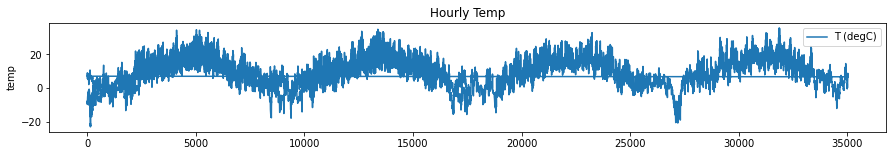

In [29]:
plt.rcParams["figure.figsize"] = (15,2)
ax=temperature.plot()
plt.ylabel('temp')
ax.set_title('Hourly Temp')
plt.show()

To perform linear regression, we follow the same step we did in Example 1. We will use the shifted (by 24-hrs) temperature data (x-variable) as the prediction variable (y-variable). We get the equation by fitting with LR and use the equation in predicting the temperature in the next 24 hours.

In [30]:
window = 24
temperature['Prediction'] = temperature[['T (degC)']].shift(-window)

In [31]:
df4 = pd.read_csv("../data/test_series.csv", usecols=['T (degC)']).iloc[:17520]
test_24 = pd.DataFrame(np.reshape(df4.values, (24, 730)))
# y_test = df4[['T (degC)']].iloc[:24]

In [32]:
X = np.array(temperature.drop(['Prediction'],1))
X = X[:-window]

y = np.array(temperature['Prediction'])
y = y[:-window]
print(X.shape)
print(y.shape)


(52536, 1)
(52536,)


In [33]:
X.flatten().shape

(52536,)

#### Simultaneous prediction of temperature in the next 24 hours
In order to make predictions for the next 24 hours, we will need to reshape our $X$ and $y$ data so that we can  use only one sample point $X$ to predict the temperature for the next 24 hours.  

In [34]:
# Divide training data into 24 hour chunks
# Use 1 Temperature measurement to predict the next 24 hours
X_new = temperature['T (degC)'].iloc[:-window].values.reshape(-1, 24)[:,-1].reshape(-1,1)
y_new = temperature['Prediction'].iloc[:-window].values.reshape(-1, 24)
X_new.shape, y_new.shape

((2189, 1), (2189, 24))

In [35]:
print(X_new)

[[-4.5 ]
 [-4.45]
 [-2.46]
 ...
 [ 0.86]
 [-3.54]
 [-8.26]]


We create a vector that will contain the outputs of the fit.

In [36]:
lr_vectoroutput = LinearRegression()
fit = lr_vectoroutput.fit(X_new, y_new)

Now, we divide the test data into 24 hour chunks, which will serve as our test sets. The average MAE of these test sets will be calculated to see how Univariate LR performs in predicting the temperature in the next 24 hrs.

In [37]:
X_test = np.vstack([temperature['T (degC)'].iloc[-window:].values.reshape(1,-1),
                    test_24.iloc[:, :-1].values.T])[:,-1].reshape(-1,1)
y_test = test_24.values.T

In [38]:
## predict for every 24 hrs in test_series
MAE = []
y_pred = lr_vectoroutput.predict(X_test)
for i in range(len(y_test)):
    MAE.append(metrics.mean_absolute_error(y_test[i], y_pred[i]))
print(f"The average Mean Absolute Error is for {len(y_test)} sets of 24-hr data: ", sum(MAE)/730)

The average Mean Absolute Error is for 730 sets of 24-hr data:  9.067496890754962


We see that the average MAE is 9.067496890754962, which shows that LR is not a good model for forecasting the next 24-hr temperature using the Jena Climate Data. 

### Example 3: Multivariate Linear Regression and Regularization Techniques
In the previous example, we used univariate LR to demonstrate forecasting time series. In this example, we would like to demonstrate LR for a case where there are more than 1 independent variable, called the multivariate linear regression. To start off, we demonstrate the LR model first using a simple data on cars downloaded from one of the references. Take note that this is not yet forecasting in time series, but just a simple demonstration how multivariate LR works.

In [39]:
#creating dataframe for simple data on cars
cars = pd.read_csv('../data/cars.csv')
cars.head()

,Car,Model,Volume,Weight,CO2
0,Toyoty,Aygo,1000,790,99
1,Mitsubishi,Space Star,1200,1160,95
2,Skoda,Citigo,1000,929,95
3,Fiat,500,900,865,90
4,Mini,Cooper,1500,1140,105


In [40]:
cars.describe()

,Volume,Weight,CO2
count,36.000000,36.000000,36.000000
mean,1611.111111,1292.277778,102.027778
std,388.975047,242.123889,7.454571
min,900.000000,790.000000,90.000000
25%,1475.000000,1117.250000,97.750000
50%,1600.000000,1329.000000,99.000000
75%,2000.000000,1418.250000,105.000000
max,2500.000000,1746.000000,120.000000


In [41]:
from sklearn.linear_model import LinearRegression

# We will model C02 emission (as y variable) using the parameters volume and weight as predictors (x variable)
# for a multi-variate linear regression

params = ['Volume', 'Weight']
X = cars[params]
y = cars['CO2']

# fitting the data with linear regression
lrm = LinearRegression()
model = lrm.fit(X, y)

# coefficients of the fit are as follows:
b = model.intercept_
m = model.coef_

print("Using Multivariate Linear Regression, we have the following equation: ")
print('CO2= ', m[0], 'x1 + ', + m[1], 'x2 + ', b)

#We want to predict CO2 emission given specific weight and volume -- both 1000
model.predict([[1000, 1000]])

Using Multivariate Linear Regression, we have the following equation: 
CO2=  0.0078052575277471215 x1 +  0.007550947270300686 x2 +  79.6947192911594


array([95.05092409])

#### Interpretation of coefficients:

The slope for volume and weight of the cars are equal to 0.00781 and 0.00755, respectively. This means that for every 1 unit change in volume (weight) of cars, the expected increase in CO2 emission is 0.00781% (0.00755%).

In [42]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_pred = lrm.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 5.670405502652306


#### Interpretation of metrics:

We can see that the value of mean absolute error is 5.67, which is less than 6% of the mean value of the CO2 emission. This means that our prediction is good.


For multi-variate linear regression, sometimes we do not know which among the parameters are relevant to the prediction. Thus in order to make our predictions more accurate, we need to penalize the less relevant parameters (or basically decrease their effect on our predictions and sometimes let them approach zero). This is usually done using regularization techniques.

### L1 (Lasso) and L2 (Ridge) regularization for multi-variate linear regression
Regularization techniques is based on the idea that proper constraining the allowed values of variables will increase the accuracy. In this notebook, we will use two techniques:

#### Lasso Regularization 
- It puts constraints on the absolute value of the coefficients.

#### Ridge Regularization 
- It puts contraints on the square of the coefficients.

#### L1 Regularization

In [43]:
# Lasso Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.01, normalize=True)
model3 = lassoreg.fit(X, y)


# coefficients of the fit are as follows:
b = model3.intercept_
m = model3.coef_

print("Using Multivariate Linear Regression, we have the following equation: ")
print('CO2= ', m[0], 'x1 + ', + m[1], 'x2 + ', b)

Using Multivariate Linear Regression, we have the following equation: 
CO2=  0.007716758354774065 x1 +  0.007406759259298173 x2 +  80.02363225450095


In [44]:
y_pred = lassoreg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 5.655740800489042


#### L2 Regularization

In [45]:
# Ridge Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.1, normalize=True)
model2 = ridgereg.fit(X, y)

# coefficients of the fit are as follows:
b = model2.intercept_
m = model2.coef_

print("Using Multivariate Linear Regression, we have the following equation: ")
print('CO2= ', m[0], 'x1 + ', + m[1], 'x2 + ', b)

Using Multivariate Linear Regression, we have the following equation: 
CO2=  0.007019810017740837 x1 +  0.007728894654883425 x2 +  80.73020505101513


In [46]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_pred = ridgereg.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 5.610220319986732


### Example 4: Multi-variate Linear Regression on Jena Climate Data
In this section, we use the climate data to demonstrate forecasting using multivariate linear regression and regularization. The idea of forecasting method in this example is different from the method used in Example 1. In Example 1, we used the lagged value of the close prices of NFLX, i.e., we predicted $y_{T,t}$ using the lagged value $y_{T-30}$. In this example, we will use different variables $x_{1,t}$, $x_{2,t}$,..., $x_{n,t}$, where n is the total number of variables used to predict y. In this case, n=14.

In [47]:
train_df = pd.read_csv('../data/train_series_datetime.csv',index_col=0)
val_df = pd.read_csv('../data/val_series_datetime.csv',index_col=0)
data = pd.concat([train_df, val_df])
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
12,01.01.2009 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
18,01.01.2009 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
24,01.01.2009 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


In [48]:
data.describe()
# print(data.shape)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000,52569.000000
mean,988.705288,9.194491,283.277435,4.788269,76.393381,13.377285,9.463628,3.913601,5.980737,9.573651,1216.601158,2.142079,3.538136,173.890127
std,8.175879,8.536547,8.606957,6.921408,16.456302,7.581065,4.201507,4.735824,2.666735,4.252759,40.422708,1.531838,2.313626,87.475968
min,914.100000,-23.010000,250.600000,-25.010000,14.200000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.510000,0.000000,0.000000,0.000000
25%,983.740000,3.140000,277.290000,0.130000,65.690000,7.660000,6.170000,0.810000,3.890000,6.240000,1187.930000,1.000000,1.780000,121.800000
50%,989.130000,9.340000,283.450000,5.220000,79.700000,11.760000,8.860000,2.100000,5.600000,8.970000,1213.250000,1.780000,3.000000,196.800000
75%,994.040000,15.310000,289.390000,10.030000,89.700000,17.420000,12.320000,5.170000,7.790000,12.460000,1242.850000,2.880000,4.760000,234.200000
max,1012.840000,35.650000,309.590000,23.110000,100.000000,58.340000,28.320000,42.120000,18.130000,28.820000,1392.100000,13.590000,21.580000,360.000000


To be consistent with all the other forecasting models, we manually set the first 300k+ data for training while the last 100k+ data points as test set.

In [49]:
data_train = data.iloc[:, 1:15]
print(data.shape)

(52569, 15)


In [50]:
x_train = data_train[['p (mbar)', 'Tpot (K)', 'Tdew (degC)', 'H2OC (mmol/mol)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']]
y_train = data_train['T (degC)']

In [51]:
data_train.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
6,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
12,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
18,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
24,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


In [52]:
data_train.shape

(52569, 14)

Again, for consistency with all the other forecasting models in this book, we use the same test set, which is the last 100k+ data.

In [53]:
data_test = pd.read_csv('../data/test_series.csv')
data_test.head()
print(data.shape)

(52569, 15)


In [54]:
x_test = data_test[['p (mbar)', 'Tpot (K)', 'Tdew (degC)', 'H2OC (mmol/mol)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']]
y_test = data_test[['T (degC)']]

In [55]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [56]:
y_pred = lr.predict(x_test)

In [57]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.0074509637143215


We can see that the value of MAE error is 0.007635891353557461. This means that linear regression is good for this dataset if all the parameters are used. Now we try to use the regularization techniques if the errors will improve.

#### L1 Regularization


In [58]:
# Lasso Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Lasso
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
lassoreg2 = Lasso(alpha=0.01, normalize=True)
model_temp2 = lassoreg2.fit(x_train, y_train)

In [59]:
y_pred3 = lassoreg2.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred3))

Mean Absolute Error: 1.832850814670404


L1 Regularization has worse performance having large errors, based on the metrics.

#### L2 Regularization

In [60]:
# Ridge Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Ridge
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

ridgereg2 = Ridge(alpha=0.01, normalize=True)
model_temp = ridgereg2.fit(x_train, y_train)
y_pred2 = ridgereg2.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))

Mean Absolute Error: 0.11708568925419785


Using L2 regularization, penalizing the other parameters didn't lead to significant improvement in the prediction.

#### Simultaneous prediction of the temperature for the next 24 hours
In this part, we perform the same re-shaping of the data similar to what we did above when we applied univariate linear regression and use one sample point from each of the 730 24-hr test set described in Example 2 to predict the temperature for the next 24 hours. 

In [61]:
x_train = data_train[['p (mbar)', 'Tpot (K)', 
                      'Tdew (degC)', 'H2OC (mmol/mol)', 
                      'rh (%)', 'VPmax (mbar)', 
                      'VPact (mbar)', 'VPdef (mbar)', 
                      'sh (g/kg)', 'rho (g/m**3)', 
                      'wv (m/s)', 'max. wv (m/s)', 
                      'wd (deg)']].iloc[:len(data_train)-len(data_train)%24]
y_train = data_train['T (degC)'].iloc[:len(data_train)-len(data_train)%24]

X_new = x_train.iloc[::24].values
y_new = y_train.values.reshape(-1, 24)

In [62]:
lr_sim = LinearRegression()
lr_sim.fit(X_new, y_new)

LinearRegression()

In [63]:
x_test_new = data_test[['p (mbar)', 'Tpot (K)', 
                       'Tdew (degC)', 'H2OC (mmol/mol)', 
                       'rh (%)', 'VPmax (mbar)', 
                       'VPact (mbar)', 'VPdef (mbar)', 
                       'sh (g/kg)', 'rho (g/m**3)', 
                       'wv (m/s)', 'max. wv (m/s)', 
                       'wd (deg)']].iloc[:len(data_test)-len(data_test)%24].iloc[::24].values
y_test_new = data_test[['T (degC)']].iloc[:len(data_test)-len(data_test)%24].values.reshape(-1, 24)

In [64]:
## predict for every 24 hrs in test_series
MAE = []
y_pred = lr_sim.predict(x_test_new)
for i in range(len(y_test_new)):
    MAE.append(metrics.mean_absolute_error(y_test_new[i], y_pred[i]))
print(f"The average Mean Absolute Error is for {len(y_test_new)} sets of 24-hr data: ", sum(MAE)/730)

The average Mean Absolute Error is for 730 sets of 24-hr data:  2.859973277766325


We can see that the MAE improved compared to the MAE when we forecasted the temperature for the next 24 hours using univariate LR.

## Momentum and Trend Forecasting
Now let us move to common tools in momentum and trend forecasting. We will see that these two topics on momentum and trend goes together, i.e., the momentum forecasting is based on the usage of trend forecasting. In this section, we will discuss by considering the applications in technical analysis and strategies in stock trading. In this are, the most common used tools are 
1. Moving Average
2. Momentum



### Moving Average MA

MA trading rule is the most popular trading tool for traders. The trading signal or indicator is normally derived by first computing for the average closing price over a window of size $n$, with the following formula:

$MA_{n}(t) = \frac{w_{0}P_{t}+ w_{1}P_{t-1}+ w_{2}P_{t-2}+...+ w_{n-1}P_{t-n+1}}{w_{0}+ w_{1}+ w_{2}+... + w_{n-1}}$ (1)

$MA_{n}(t) = \frac{\sum\limits _{i=0} ^{n-1} w_{i}P_{t-i}}{\sum\limits _{i=0} ^{n-1} w_{i}}$ (2)

There are three types of MA and they are as follows:
1. Simple Moving Average (SMA) - all prices are weighted equally such that $w_{i}=1$ in equations (1, 2). 

2. Linear Moving Average (LMA) - the weights change, putting more relevance to the prices closer to the current price such that $w_{i}= n-i$

3. Exponential Moving Average (EMA) - similar to LMA, bigger weights are assigned to more recent prices and the weights drop exponentially. There are several ways proposed to compute the weights in EMA. We will discuss here the general formulation of EMA given as:

$EMA(n) = \frac{2}{n+1}P_{t} + (1- \frac{2}{n+1}) P_{t-1}$

Using these tools, if the current price is higher that a moving average over past $n$ periods, the signal is "buy". 

Momentum on the other hand, in its simplest form, is just the difference in the current price and the price $n$ days ago. In other definitiions it can also be a change in the simple moving average with a scale factor of $N+1$:

$\frac{MOM}{N+1} = SMA_{today}- SMA_{yesterday}$

In trading, the indicators for both tools is given as:

1. Moving average:
$I_{t}(n) = P_{t}- MA_{n}$

2. Momentum
$I_{t}(n) = P_{t}-P_{t-n+1}$

The trader is suggested to buy if $I>0$ and sell otherwise.

To understand these concepts in financial analysis more in depth, we will look at various examples in trading. But first, we will demonstrate using the climate data that MA trends are also used in smooting time series data. After which, we will proceed with the examples on stock price analysis.

### Example 5: Extracting the Trend in Climate Data Using MA
First, let us try to apply MA to see a smoother trend of the temperature measurements in the climate data. Here, we will use the simple MA and the exponential MA.

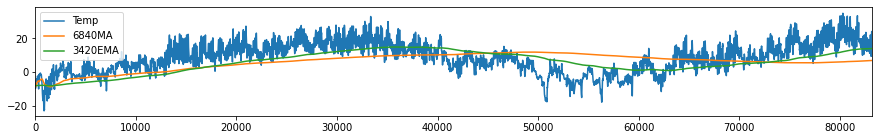

In [65]:
# 3420 data is equivalent to 1 month while 83220 is equivalent to two years, 124830 for 3 years
data['MA'] = data['T (degC)'].rolling(window=6840, min_periods=1).mean()
data['EMA'] = data['T (degC)'].ewm(span=3420, adjust=False).mean()

plt.rcParams["figure.figsize"] = (15,2)
data['T (degC)'].plot(label= 'Temp')
data['MA'].plot(label= '6840MA')
data['EMA'].plot(label= '3420EMA')

plt.xlim([0, 83220])
plt.legend(loc='upper left')

Looking at our data, we can see that there is an apparent seasonal trend of temperature measurements and at this point, we might be interested to know which among the factors in the data are causing this trend in temperature. This concept is called causation and it will be discussed at a later chapter in this book.

### Momentum Strategies
Momentum is used as a measure of strength of the current or future trend regardless of the direction, i.e., whether it will go up or down. It is purely a technical analysis technique and does not consider the fundamentals of the company. Traders use momentum strategy for short-term, when the trends are strong or when the price action momentum is high. An indicator of high momentum is the price advancing or declining over a wide range in a short period of time. High levels of momentum indicates increased volatility, too.

Momentum investors tries to understand and anticipate the behavior of the market, since awareness of the biases and emotions of other investors make the momentum investing strategy to work better.

#### How to apply momentum strategy:
1. A trader checks the existence of trends using indicators such as trend lines, moving averages, and  ADX to identify the existence of a trend.
2. As the trend gains momentum – strengthens – the trader decides what position to take following the direction of the trend (buy an uptrend; sell a downtrend).
3. A trader exits when the momentum of the trend shows signs of weakening. Divergence between price action and the movement of momentum indicators such as the MACD or RSI is a usual indicator.

### Example 6: Momentum Trading Strategy Using Two MA's
As mentioned above, momentum strategy can be applied after checking for trends using moving averages. SMA and EMA are widely used in technical analysis of stock prices and in generating buy/sell signals. The basic idea is to use two different windows (short and long observation window) and see where the two MA's cross over. A shorter window reacts faster to price changes than a longer window. Thus if MA(n=short) > MA(n=long), the trading strategy or signal is to buy. Otherwise, the signal is to sell. 

SMA works fine in technical analysis however, it's behavior lags the current price by $n/2$ days. This means that the changes in the trend can only be seen after the lag days making the strategy being delayed. EMA reduces this lag significantly as weights are decaying exponentially. The same strategy of looking for crossovers between two EMAs with short and long window of observation is always applied, i.e., a signal to buy is generated when the EMA with shorter window crosses above the EMA with longer observation window.

Now let us demonstrate this idea using the Netflix data on how to use MA and EMA in making signals or decisions whether to buy or sell the stock.


Text(0, 0.5, 'Price')

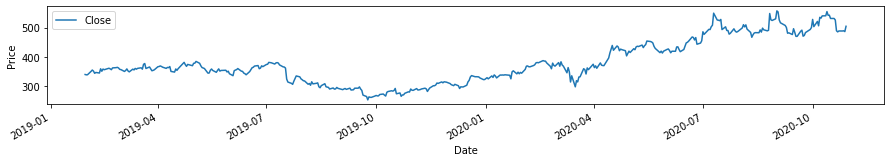

In [66]:
# Recall Netflix data we used above in forecasting using linear regression (LR)
plt.rcParams["figure.figsize"] = (15,2)
price.plot()
plt.ylabel('Price')

We will use window size of n=25 for the short MA and n=65 for the long MA.

In [67]:
## In pandas, the rolling windows is available in computing for the mean of a window sized-n. 
price['20MA'] = price['Close'].rolling(window=20, min_periods=1).mean()
price['65MA'] = price['Close'].rolling(window=65, min_periods=1).mean()

We will try to locate the crossover of the two MAs and create an 'indicator' of crossover. Note that this indicator is not exactly the same as the indicator "I" discussed above. Afterwhich, we will create our strategy based on the generated indicators.. The strategy is based on the movement of price.

If MA20> MA65, we have indicator equal to +1.0, otherwise indicator equal to 0.0. Once there is a crossover, there is a reversal of the positions of MA20 and MA65. Thus getting the difference between the indicators ($I_{diff} = I_{t} - I{t-1}$) for two consecutive times will tell us if the reversal is positive (buy) or negative (sell).

In [68]:
price['Indicator'] = 0.0
price['Indicator'] = np.where(price['20MA']> price['65MA'], 1.0, 0.0)

# To get the difference of the indicators, we use function diff in pandas.
price['Decision'] = price['Indicator'].diff()
# print(price)

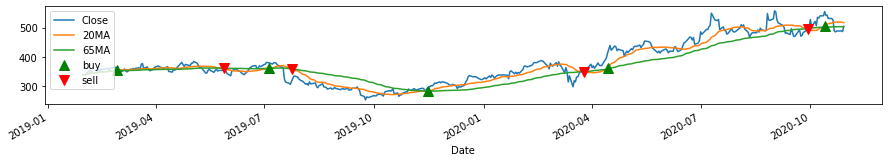

In [69]:
#Decision=+1 means buy, while Decision=-1 means sell
# plotting them all together 
price['Close'].plot(label= 'Close')
price['20MA'].plot(label = '20MA')
price['65MA'].plot(label = '65MA')

plt.plot(price[price['Decision'] == 1].index, price['20MA'][price['Decision'] == 1], '^', markersize = 10, color = 'g' , label = 'buy')
plt.plot(price[price['Decision'] == -1].index, price['20MA'][price['Decision'] == -1],  'v', markersize = 10, color = 'r' , label = 'sell')
plt.legend(loc='upper left')

Using two MA's and getting their crossover or difference as indicator, we can decide whether to buy (green) the stock or sell (red). We can do the same process we did above using EMA.

In [70]:
# In pandas, the rolling window equivalent for EMA is 
price['20EMA'] = price['Close'].ewm(span=20, adjust=False).mean()
price['65EMA'] = price['Close'].ewm(span=65, adjust=False).mean()

In [71]:
# Like how we used MA above, we will try to locate the crossover of the two EMAs and create an indicator of crossover 
price['Indicator_EMA'] = 0.0
price['Indicator_EMA'] = np.where(price['20EMA']> price['65EMA'], 1.0, 0.0)

price['Decision_EMA'] = price['Indicator_EMA'].diff()
# print(price)

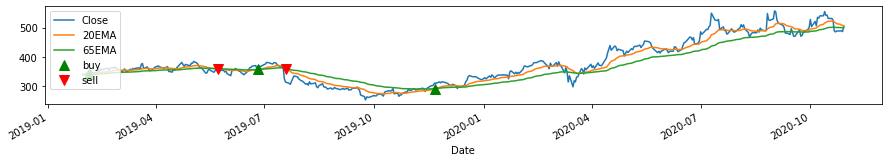

In [72]:
# Decision=+1 means buy, while Decision=-1 means sell
# plotting them all together 
plt.rcParams["figure.figsize"] = (15,2)
price['Close'].plot(label= 'Close')
price['20EMA'].plot(label = '20EMA')
price['65EMA'].plot(label = '65EMA')

plt.plot(price[price['Decision_EMA'] == 1].index, price['20EMA'][price['Decision_EMA'] == 1], '^', markersize = 10, color = 'g' , label = 'buy')
plt.plot(price[price['Decision_EMA'] == -1].index, price['20EMA'][price['Decision_EMA'] == -1],  'v', markersize = 10, color = 'r' , label = 'sell')
plt.legend(loc='upper left')

For this case, the momentum indicators generally helps us generate decisions whether to buy or not. The crossover is a sign of reversal of trend. In the context of technical analysis, "To buy" predicts that the price will increase, while "To Sell" predicts that the price will decrease.

These tools work in general but there are more sophisticated tools that can be used in doing technical analysis.


### Example 7: Momentum Trading Strategy Using MACD
There are many Momentum Trading Strategies that can be used. In this example, we will use the Moving Average Convergence Divergence (MACD). MACD is one of the most popular momentum indicators, which makes use of the difference between two exponential moving averages (12-day and 26-day) and compare it with EMA (9-day) of MACD.

#### MACD Indicators
1. bullish crossover (buy) -  occurs when MACD crosses above the signal line. 
2. bearish signal (sell) - MACD crosses below the signal line. 
3. overbought or oversold - crossover has a high sloping MACD, depending on if the crossover is bullish or bearish respectively. A correction or reversal of direction will soon follow.
4. on movement - weak movement, indicated by the small slope of MACD has a high chance to correct while a strong movement highly probable to continue.


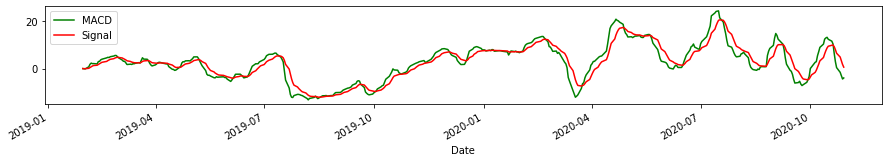

In [73]:
price['exp1'] = price['Close'].ewm(span=12, adjust=False).mean()
price['exp2'] = price['Close'].ewm(span=26, adjust=False).mean()
price['macd'] = price['exp1']-price['exp2']
price['exp3'] = price['macd'].ewm(span=9, adjust=False).mean()

price['macd'].plot(color = 'g', label = 'MACD')
price['exp3'].plot(color = 'r', label = 'Signal')
plt.legend(loc='upper left')

plt.show()


In [74]:
# Like how we used MA above, we will try to locate the crossover of the MACD and the Signal and plot the indicators 
price['Indicator_MACD'] = 0.0
price['Indicator_MACD'] = np.where(price['macd']> price['exp3'], 1.0, 0.0)

price['Decision_MACD'] = price['Indicator_MACD'].diff()
# print(price)

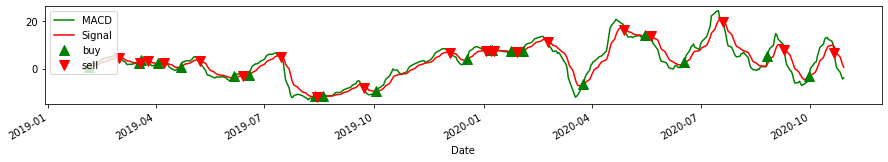

In [75]:
price['macd'].plot(color = 'g', label = 'MACD')
price['exp3'].plot(color = 'r', label = 'Signal')
plt.legend(loc='upper left')

plt.plot(price[price['Decision_MACD'] == 1].index, price['macd'][price['Decision_MACD'] == 1], '^', markersize = 10, color = 'g' , label = 'buy')
plt.plot(price[price['Decision_MACD'] == -1].index, price['macd'][price['Decision_MACD'] == -1],  'v', markersize = 10, color = 'r' , label = 'sell')
plt.legend(loc='upper left')

In the plot above, we can see the approximate dates where a bullish (buy) and bearish (sell) crossover happened. Now we want to examine the strength and identify overbought and oversold conditions. Here we use the same parameters, but we plot the original price and its MACD.

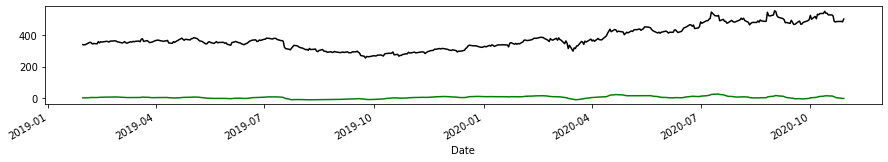

In [76]:
price['Close'].plot(color = 'k', label= 'Close')
price['macd'].plot(color = 'g', label = 'MACD')
plt.show()

Here, MACD stays somehow flat but notice that there are times where the MACD curve is steeper than other times, indicative of overbought or oversold conditions (e.g. before 2020-04).  Zooming-in to the MACD plot to see the slopes, we have the ff:

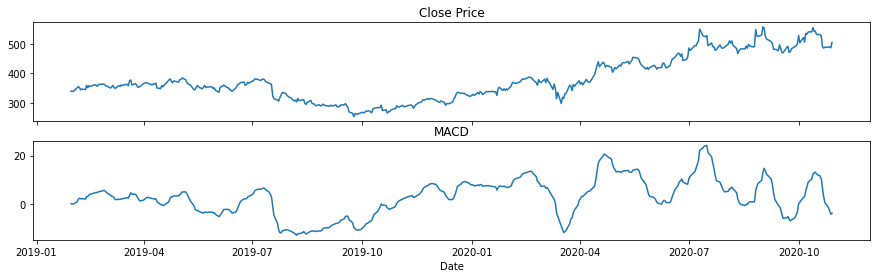

In [77]:
fig, axs = plt.subplots(2, figsize=(15, 4), sharex=True)
axs[0].set_title('Close Price')
axs[1].set_title('MACD')
axs[0].plot(price['Close'], label='Close')
axs[1].plot(price['macd'], label='macd')
axs[1].set(xlabel='Date')
plt.show()

From the above plots, the steep slopes of MACD happened before 2020-04 (oversold) and 2020-10 (overbought). Note that there are still some steep sloped in MACD after 2020-07 and could be indicative of other instances of overbuying and overselling. 

Finally, as discussed above, there are other momentum indicators that are used in trading such as RSI and ADX. The reader is left to explore on them following the procedure presented in this notebook.

## Summary
In this chapter we discussed and demonstrated how we can use forecasting tools such as linear, trend, and momentum. Compared to the previous chapter, we noted here that there is no need to check for the stationarity of the time series and there is no need for differencing. We also showed that linear regression (and multi-variate LR) is limited and performs poorly when applied to some data. Finally we emphasized that while other forecasting tools require the removal of trends, in this notebook we showed that trends can be utilized to predict the future direction of the data.

## Preview to the next chapter...
As simple as it is, the forecasting methods discussed here are not applicable in many other cases. Following our discussion, the next chapters will provide better forecasting models. In Chapter 3, the concept of vector autoregressive model (VAR) which is pressumed to be a better tool in forecasting time series data as it can incorportate information from the previous time step of another data, will be discussed. 




## References
The discussions in this notebook were made with the help of the following references
* https://www.tandfonline.com/doi/pdf/10.1080/14697688.2020.1716057?needAccess=true
* https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0
* https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089
* https://otexts.com/fpp2/autocorrelation.html
* https://www.w3schools.com/python/python_ml_multiple_regression.asp
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
* https://www.investopedia.com/articles/trading/09/linear-regression-time-price.asp
* https://medium.com/@harishreddyp98/regularization-in-python-699cfbad8622
* https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
* https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/momentum-investing/